(pre-processing:dimensionality-reduction)=
# Dimensionality Reduction

scRNA-seq is a high-throughput sequencing technology that produces datasets with high dimensions in the number of cells and genes.
Therefore, scRNA-seq data suffers from the 'curse of dimensionality'. 

```{admonition} Curse of dimensionality
:class: dropdown
The Curse of dimensionality was first brought up by R. Bellman {cite}`bellman1957dynamic` and describes that, in theory, high-dimensional data contains more information, but in practice this is not the case.
Higher-dimensional data often contains more noise and redundancy, and therefore, adding more information does not provide benefits for downstream analysis steps. 
```

Not all genes are informative and therefore not all genes are essential for tasks such as clustering.
We already aimed to reduce the dimensionality of the data with feature selection.
As a next step, we will further reduce the dimensions of single-cell RNA-seq data with dimensionality reduction algorithms. 
These algorithms are an important step during preprocessing to reduce the data complexity and for visualization.

:::{figure-md} Dimensionality reduction

<img src="../_static/images/preprocessing_visualization/dimensionality_reduction.jpeg" alt="Dimensionality reduction" class="bg-primary mb-1" width="800px">

Dimensionality reduction embeds the high-dimensional data into a lower-dimensional space.
The low-dimensional representation still captures the underlying structure of the data while having as few dimensions as possible.
Here we visualize a three-dimensional object projected into two dimensions. 

:::

Xing et al. compared in an independent comparison the stability, accuracy, and computing cost of 10 different dimensionality reduction methods {cite}`Xiang2021`.
They propose to use t-distributed stochastic neighbor embedding (t-SNE) as it yielded the best overall performance.
Uniform manifold approximation and projection (UMAP) showed the highest stability and separated the original cell populations best.
An additional dimensionality reduction worth mentioning in this context is principal component analysis (PCA), which is still widely used.

Generally, t-SNE and UMAP are very robust and mostly equivalent if specific choices for the initialization are selected {cite}`Kobak2019`.

All aforementioned methods are implemented in scanpy.

Now we start with importing all required Python packages and load the dataset after [quality control](quality_control.ipynb), [normalization](normalization.ipynb), and [feature selection](feature_selection.ipynb). 

In [1]:
import lamindb as ln
import scanpy as sc

# Suppress verbose logging from Scanpy
sc.settings.verbosity = 0

# Set figure parameters for clean, minimal plots
sc.settings.set_figure_params(dpi=80, facecolor="white", frameon=False)

assert ln.setup.settings.instance.slug == "theislab/sc-best-practices"

ln.track()

→ connected lamindb: theislab/sc-best-practices
→ loaded Transform('liGMVGre4G5H0000'), re-started Run('ZFh04bqi...') at 2025-05-13 03:27:34 UTC
→ notebook imports: lamindb==1.3.2 scanpy==1.11.1


In [2]:
af = ln.Artifact.get(
    key="preprocessing_visualization/s4d8_feature_selection.h5ad", is_latest=True
)
adata = af.load()

We will use a normalized representation of the dataset for dimensionality reduction and visualization, specifically the shifted logarithm.

```{admonition} Why should you use normalized data for dimensionality reduction?
:class: dropdown

First, gene expression data is typically heavily right-skewed with many zeros and a few highly expressed genes.
Log transformation helps normalize this distribution, making it more symmetric and reducing the impact of extreme values.
This prevents highly expressed genes from dominating any distance calculations.

Second, biological signals in expression data often follow multiplicative rather than additive patterns.
Log transformation converts multiplicative relationships to additive ones, which most dimensionality reduction algorithms (PCA, t-SNE, UMAP) are designed to detect.

Third, variance in raw expression data typically scales with mean expression levels.
Log transformation stabilizes this variance, preventing highly expressed genes from dominating the analysis.
For zero values (dropout events common in single-cell data), a pseudocount is typically added before log transformation (log1p) to avoid mathematical errors.
```

In [3]:
adata.X = adata.layers["scran_normalization"]

We start with:

(preprocessing-visualization-dimensionality-reduction-key-takeaway-1)=
## PCA

In our dataset, each cell is a vector of a `n_var`-dimensional vector space spanned by some orthonormal basis.
As scRNA-seq suffers from the 'curse of dimensionality', we know that not all features are important to understand the underlying dynamics of the dataset and that there is an inherent redundancy{cite}`grun2014validation`.
PCA creates a new set of uncorrelated variables, so-called principal components (PCs), via an orthogonal transformation of the original dataset.
The PCs are linear combinations of features in the original dataset and are ranked in decreasing order of variance to define the transformation.
In the ranking, the first PC typically captures the greatest amount of variance.
PCs with the lowest variance are discarded to effectively reduce the dimensionality of the data without losing information.

PCA offers the advantage that it is highly interpretable and computationally efficient.
However, as scRNA-seq datasets are rather sparse due to dropout events and therefore highly non-linear, visualization with the linear dimensionality reduction technique PCA is not very appropriate.
PCA is typically used to select the top 10-50 PCs, which are used for downstream analysis tasks.

In [4]:
# setting highly variable as highly deviant to use scanpy 'use_highly_variable' argument in sc.pp.pca
adata.var["highly_variable"] = adata.var["highly_deviant"]
sc.pp.pca(adata, svd_solver="arpack", mask_var="highly_variable")

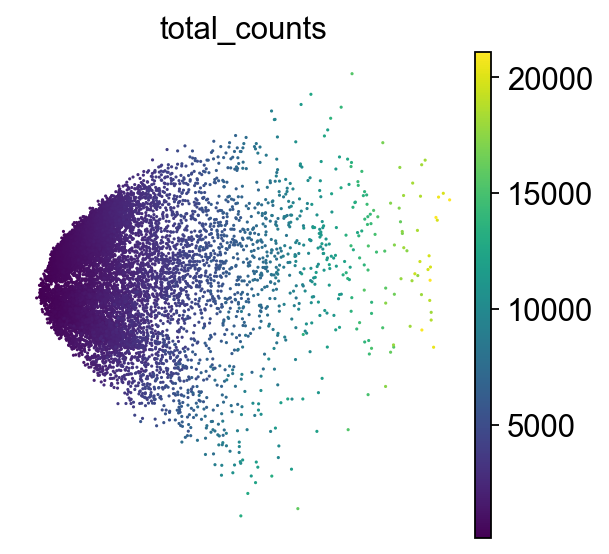

In [5]:
sc.pl.pca_scatter(adata, color="total_counts")

```{admonition} How to understand a PCA scatter plot
:class: dropdown
PCA looks for the directions in the data where the values of the cells (or samples) differ the most.
1. Axes: PC1 and PC2 are the first and second principal components(directions).
         PC1 is the direction where the data is most spread out, and PC2 is the next most variable direction, perpendicular to PC1.
2. Points: Each point is a single cell.
           The color of each point represents the total number of transcripts ({term}`UMIs <Unique Molecular Identifier (UMI)>`) detected in that cell.

By projecting the data onto PC1 and PC2, we capture most of the meaningful variation in fewer dimensions.

Although we do not aim to interpret biological meaning directly from this PCA plot at this stage, we can observe cellular heterogeneity: cells with similar expression profiles tend to cluster together, which may reflect different cell types or states.
```

## t-SNE

t-SNE is a graph based, non-linear dimensionality reduction technique which projects the high dimensional data onto 2D or 3D components.
The method defines a Gaussian probability distribution based on the high-dimensional Euclidean distances between data points.
Subsequently, a Student t-distribution is used to recreate the probability distribution in a low dimensional space where the embeddings are optimized using gradient descent.

In [6]:
sc.tl.tsne(adata, use_rep="X_pca")

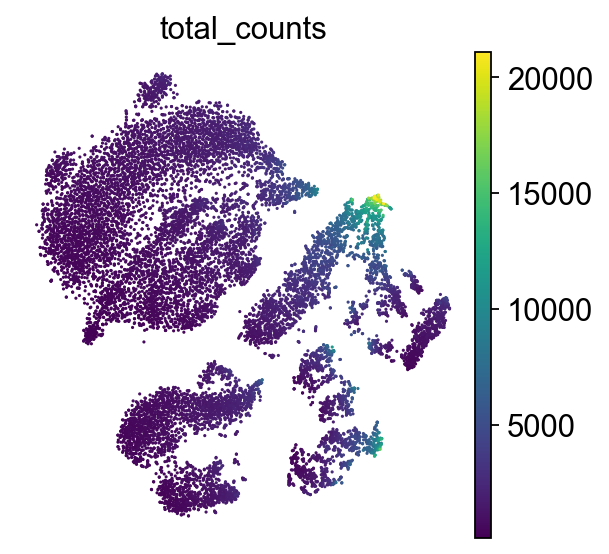

In [7]:
sc.pl.tsne(adata, color="total_counts")

```{admonition} How to understand t-SNE plot
:class: dropdown
1. Axes have no meaning!
2. Points: Each point represents a single cell.
           Color represents the total number of transcripts ({term}`UMIs <Unique Molecular Identifier (UMI)>`) detected in that cell.

This plot helps reveal cellular subpopulations: tight clusters may correspond to distinct cell types or states.
Unlike PCA, which preserves global variance, t-SNE emphasizes local structure.
For this reason, it is best practice to initialize t-SNE from PCA to reduce noise and improve stability of the embedding.
```

(preprocessing-visualization-dimensionality-reduction-key-takeaway-2)=
## UMAP

UMAP is a graph-based, non-linear dimensionality reduction technique and is principally similar to t-SNE.
It constructs a high-dimensional graph representation of the dataset and optimizes the low-dimensional graph representation to be as structurally similar as possible to the original graph.


We first calculate PCA and subsequently create a neighborhood graph based on our data.

In [8]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

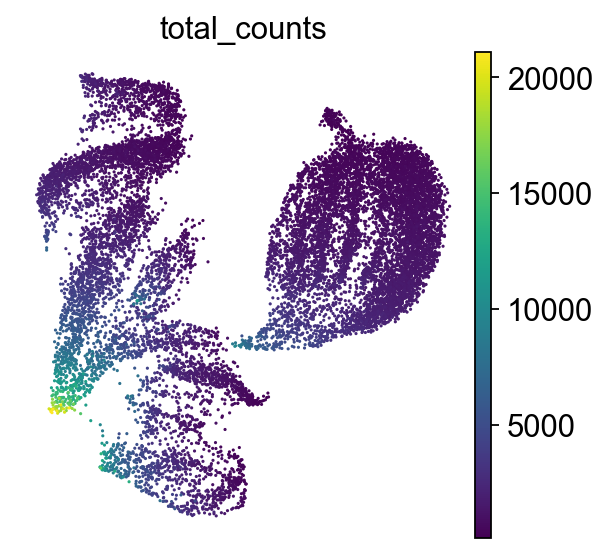

In [9]:
sc.pl.umap(adata, color="total_counts")

```{admonition} How to understand a UMAP plot
:class: dropdown
1. Axes have no meaning!
2. Points: Each point represents a single cell.  
   Color indicates the total number of transcripts ({term}`UMIs <Unique Molecular Identifier (UMI)>`) detected in that cell.

UMAP emphasizes both local and some global structure, often better preserving the overall shape of the data compared to t-SNE, i.e. similar clusters are closer together.
It constructs a neighborhood graph based on PCA-reduced data, then optimizes a low-dimensional layout that reflects relationships in the original high-dimensional space.
UMAP is widely used for visualizing cell clusters and trajectories in single-cell data.
```

## Inspecting quality control metrics 

We can now also inspect the quality control metrics we calculated previously in our PCA, TSNE or UMAP plot and potentially identify low-quality cells.

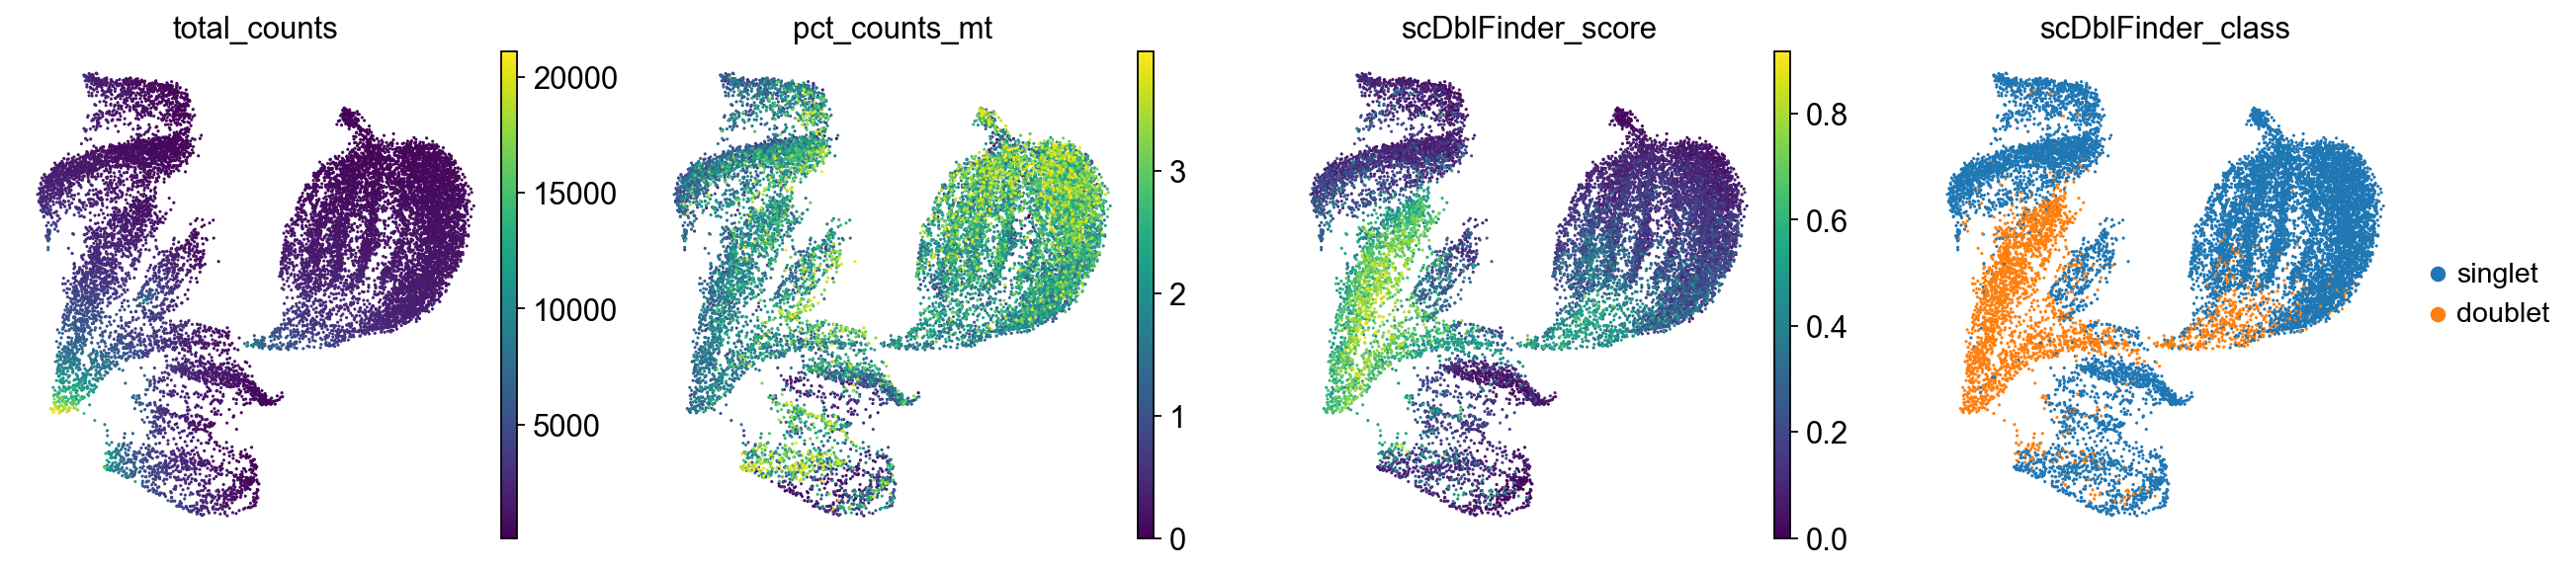

In [10]:
sc.pl.umap(
    adata,
    color=["total_counts", "pct_counts_mt", "scDblFinder_score", "scDblFinder_class"],
)

Cells with a high doublet score are projected to the same region in the UMAP.
We will keep them in the dataset for now but generally this suggests to potentially re-visit the quality control strategy again to ensure that as few doublets as possible are retained.

In [11]:
adata.write("s4d8_dimensionality_reduction.h5ad")
af = ln.Artifact(
    "s4d8_dimensionality_reduction.h5ad",
    key="preprocessing_visualization/s4d8_dimensionality_reduction.h5ad",
    description="anndata after dimensionality reduction",
).save()
af

→ creating new artifact version for key='preprocessing_visualization/s4d8_dimensionality_reduction.h5ad' (storage: 's3://lamin-eu-central-1/VPwcjx3CDAa2')
! The cache path /Users/seohyon/Library/Caches/lamindb/lamin-eu-central-1/VPwcjx3CDAa2/preprocessing_visualization/s4d8_dimensionality_reduction.h5ad already exists, replacing it.


Artifact(uid='6MXF3Uy8DkG9wy720002', is_latest=True, key='preprocessing_visualization/s4d8_dimensionality_reduction.h5ad', description='anndata after dimensionality reduction', suffix='.h5ad', otype='AnnData', size=4530494307, hash='E-h2bZDOxSnEFWk1reXptw', space_id=1, storage_id=1, run_id=10, created_by_id=5, created_at=2025-05-13 03:31:03 UTC)

## References

```{bibliography}
:filter: docname in docnames
```

## Contributors

We gratefully acknowledge the contributions of:

### Authors

* Anna Schaar
* Seo H. Kim

### Reviewers

* Lukas Heumos
